<a href="https://colab.research.google.com/github/Chanu23UOM/Obesity_Risk_Prediction_ML_Model/blob/main/OctWave_Obesity_Trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(f"Train: {train.shape}, Test: {test.shape}, PersonID in test: {'PersonID' in test.columns}")
print("Target dist:\n", train['Weight_Category'].value_counts(normalize=True))

Train: (1995, 20), Test: (855, 19), PersonID in test: True
Target dist:
 Weight_Category
Obesity_Type_I         0.168922
Obesity_Type_III       0.157393
Overweight_Level_II    0.140852
Obesity_Type_II        0.140852
Overweight_Level_I     0.138847
Normal_Weight          0.133835
Insufficient_Weight    0.119298
Name: proportion, dtype: float64


In [9]:
!pip install imbalanced-learn xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
print("Setup done—error fixed ahead!")

Setup done—error fixed ahead!


Train: (1995, 20), Test: (855, 19)
Nulls Train: 1565
Dups: 0
Num: ['Age_Years', 'Weight_Kg', 'Vegetable_Intake', 'Meal_Frequency', 'Water_Intake', 'Screen_Time_Hours', 'Family_Risk', 'Activity_Level_Score', 'Height_cm'], Cat: ['High_Calorie_Food', 'Gender', 'Family_History', 'Snack_Frequency', 'Smoking_Habit', 'Alcohol_Consumption', 'Commute_Mode', 'Physical_Activity_Level', 'Leisure Time Activity']


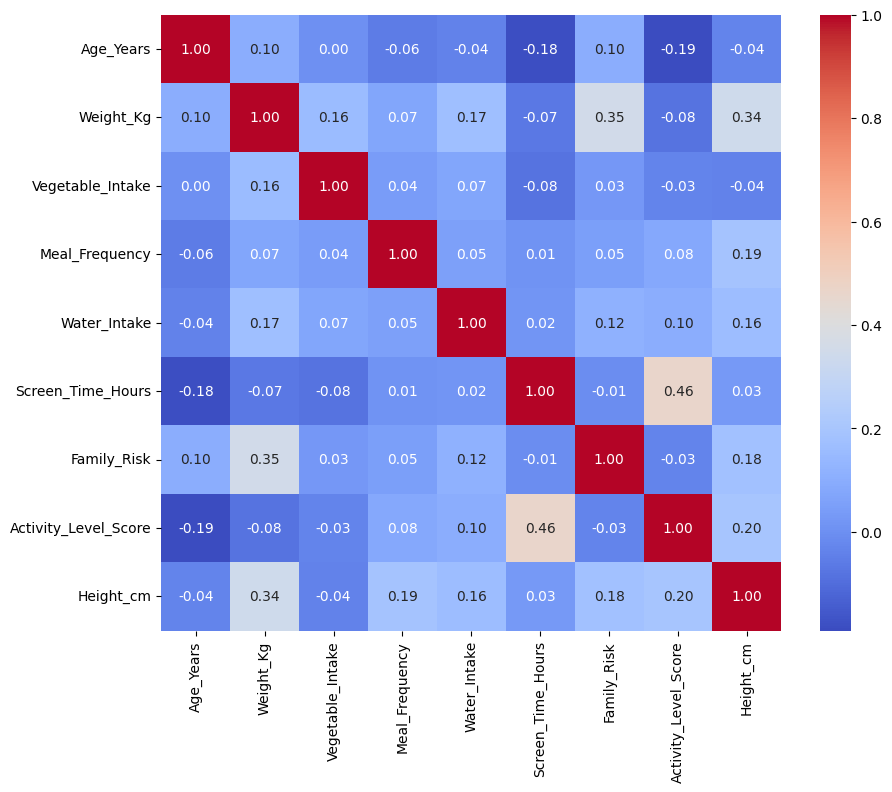

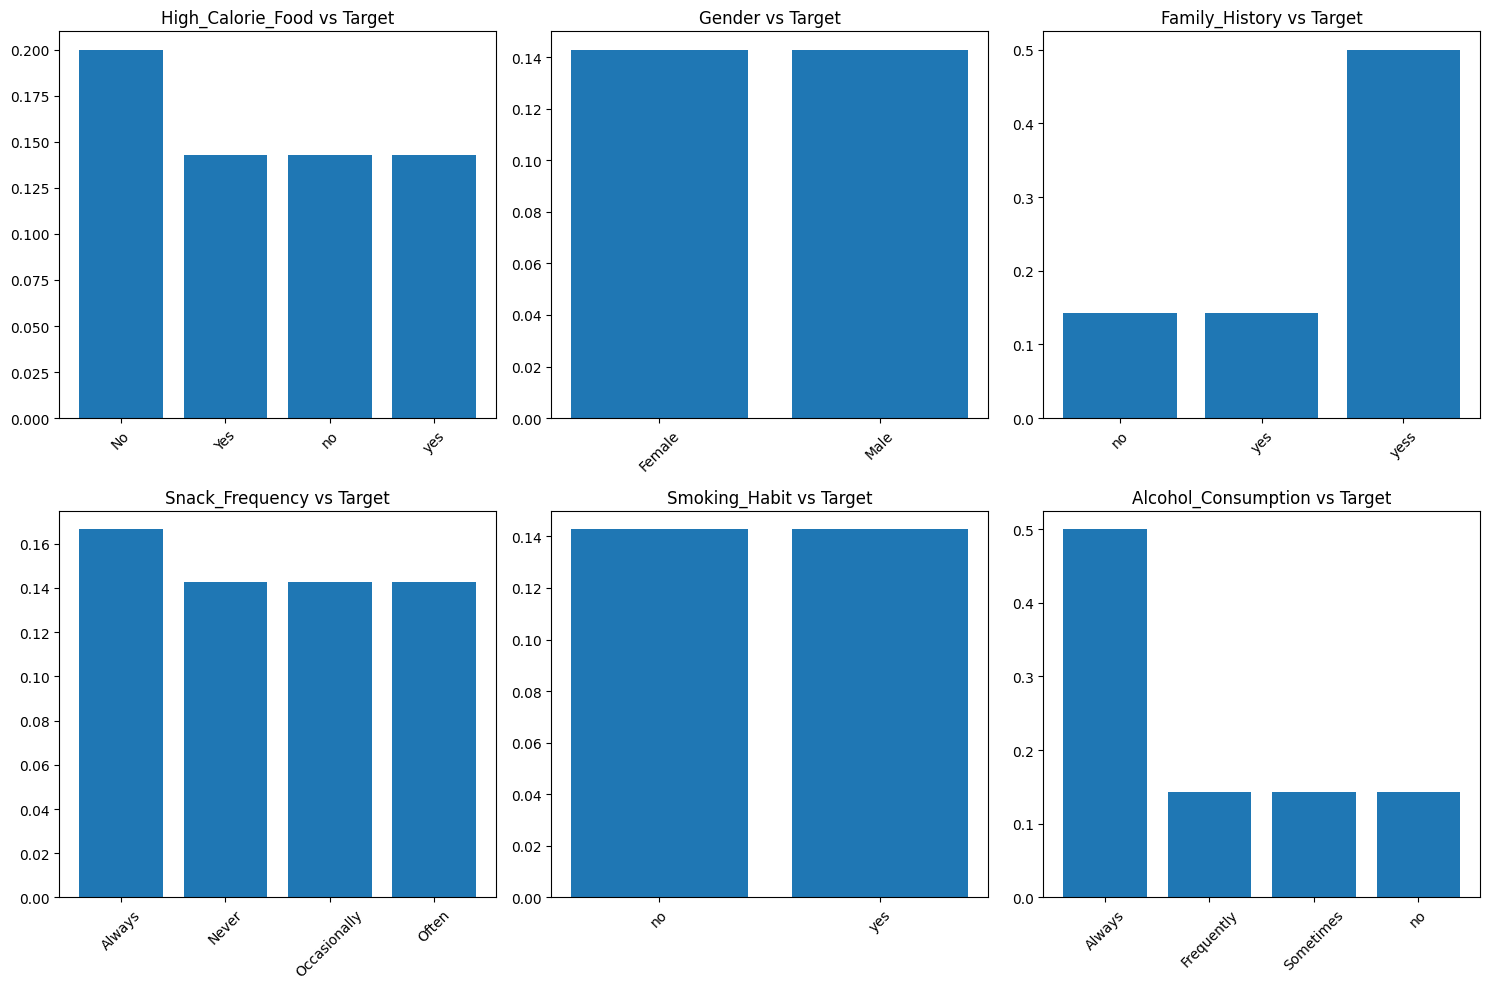

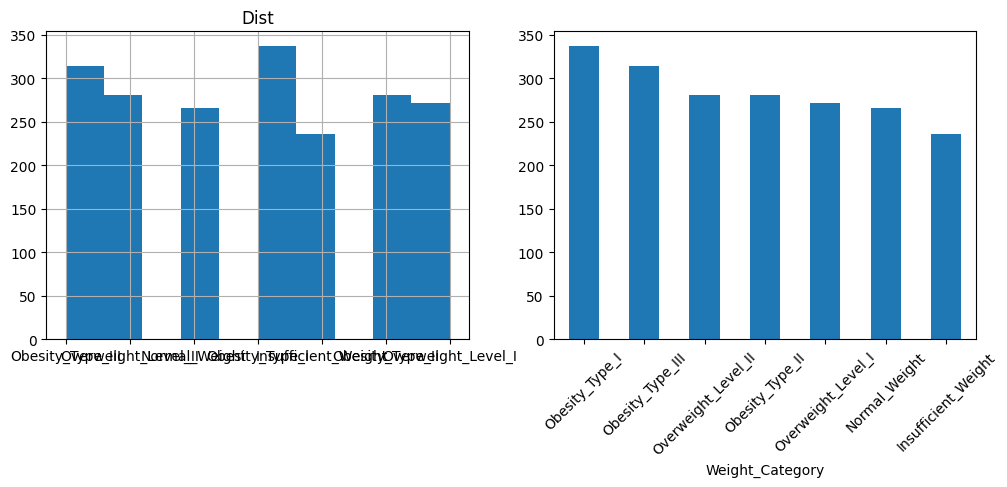

EDA: Imbalance ~25% Normal—SMOTE incoming!


In [10]:
# Load
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(f"Train: {train.shape}, Test: {test.shape}")

# Keep PersonID for sub (FIX!)
person_ids = test['PersonID'].copy()
train = train.drop('PersonID', axis=1)
test = test.drop('PersonID', axis=1)  # Now safe

# Nulls/Dups
print("Nulls Train:", train.isna().sum().sum())
train = train.drop_duplicates()
print("Dups:", train.duplicated().sum())

# Num/Cat
num_cols = train.select_dtypes(include="number").columns.tolist()
cat_cols = [c for c in train.select_dtypes(exclude="number").columns if c != 'Weight_Category']
print(f"Num: {num_cols}, Cat: {cat_cols}")

# Corr Heatmap
plt.figure(figsize=(10,8))
corr = train[num_cols + ['Weight_Category']].corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

# Cat vs Target
fig, axes = plt.subplots(2,3, figsize=(15,10))
axes = axes.flatten()
for i, col in enumerate(cat_cols[:6]):
    grouped = train.groupby(col)['Weight_Category'].value_counts(normalize=True).unstack().mean(axis=1)
    axes[i].bar(grouped.index.astype(str), grouped.values)
    axes[i].set_title(f'{col} vs Target')
    axes[i].tick_params('x', rotation=45)
plt.tight_layout()
plt.show()

# Target Dist
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
train['Weight_Category'].hist()
plt.title('Dist')
plt.subplot(1,2,2)
train['Weight_Category'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.show()
print("EDA: Imbalance ~25% Normal—SMOTE incoming!")

In [11]:
df_train = train.copy()
df_test = test.copy()

# Fixes
for df in [df_train, df_test]:
    df['High_Calorie_Food'] = df['High_Calorie_Food'].str.lower()
    df['Family_History'] = df['Family_History'].str.lower().replace('yess', 'yes')

# Bool to int
bool_cols = ['High_Calorie_Food', 'Family_History', 'Smoking_Habit']
for col in bool_cols:
    df_train[col] = (df_train[col] == 'yes').astype(int)
    df_test[col] = (df_test[col] == 'yes').astype(int)

# LabelEncode cats
le = LabelEncoder()
cate_cols = ['Gender', 'Snack_Frequency', 'Alcohol_Consumption', 'Commute_Mode', 'Physical_Activity_Level', 'Leisure Time Activity']
for col in cate_cols:
    combined = pd.concat([df_train[col], df_test[col]]).astype(str)
    le.fit(combined)
    df_train[col] = le.transform(df_train[col].astype(str))
    df_test[col] = le.transform(df_test[col].astype(str))

# Target
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(df_train['Weight_Category'])

# X/y
X_train = df_train.drop('Weight_Category', axis=1)
X_test = df_test

# Eng BMI/Age_BMI (acc boost!)
X_train['BMI'] = X_train['Weight_Kg'] / ((X_train['Height_cm']/100)**2)
X_test['BMI'] = X_test['Weight_Kg'] / ((X_test['Height_cm']/100)**2)
X_train['Age_BMI'] = X_train['Age_Years'] * X_train['BMI']
X_test['Age_BMI'] = X_test['Age_Years'] * X_test['BMI']

print(f"X_train: {X_train.shape}, Classes: {len(le_target.classes_)}")

X_train: (1986, 20), Classes: 7


In [12]:
# XGB Baseline
print("XGB Training...")
xgb = XGBClassifier(objective='multi:softprob', num_class=7, random_state=42, n_estimators=200, tree_method='gpu_hist')  # GPU!
xgb.fit(X_train, y_encoded)
train_acc = accuracy_score(y_encoded, xgb.predict(X_train))
print(f"XGB Train: {train_acc:.4f}")
cv_xgb = cross_val_score(xgb, X_train, y_encoded, cv=StratifiedKFold(5), scoring='accuracy')
print(f"XGB CV: {cv_xgb.mean():.4f}")

# SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_train, y_encoded)
print(f"Balanced: {np.bincount(y_bal)}")

# Ensemble
models = {
    'RF': RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42),
    'GB': GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=8, random_state=42),
    'ET': ExtraTreesClassifier(n_estimators=300, max_depth=20, random_state=42)
}
scores = {}
trained = {}
for name, model in models.items():
    cv = cross_val_score(model, X_bal, y_bal, cv=StratifiedKFold(5), scoring='accuracy')
    scores[name] = cv.mean()
    model.fit(X_bal, y_bal)
    trained[name] = model
    print(f'{name} CV: {cv.mean():.4f}')

# Weighted Ensemble
weights = [scores['RF'], scores['GB'], scores['ET']]
ensemble = VotingClassifier(estimators=list(trained.items()), voting='soft', weights=weights)
ens_cv = cross_val_score(ensemble, X_bal, y_bal, cv=StratifiedKFold(5), scoring='accuracy')
print(f"Ensemble CV: {ens_cv.mean():.4f}")
ensemble.fit(X_bal, y_bal)

best_model = ensemble if ens_cv.mean() > cv_xgb.mean() else xgb
print(f"Best: {'Ensemble' if ens_cv.mean() > cv_xgb.mean() else 'XGB'} (CV: {max(ens_cv.mean(), cv_xgb.mean()):.4f})")

XGB Training...
XGB Train: 1.0000
XGB CV: 0.7578
Balanced: [337 337 337 337 337 337 337]
RF CV: 0.7927
GB CV: 0.7915
ET CV: 0.7889
Ensemble CV: 0.7991
Best: Ensemble (CV: 0.7991)


In [13]:
# Predict
final_pred_encoded = best_model.predict(X_test)
final_y_pred = le_target.inverse_transform(final_pred_encoded)

# Submission (FIX: Use kept person_ids!)
submission = pd.DataFrame({'PersonID': person_ids, 'Weight_Category': final_y_pred})
submission.to_csv('octwave_fixed_sub.csv', index=False)
print(submission.head(10))
print("Pred Dist:\n", pd.Series(final_y_pred).value_counts(normalize=True))

# Top Feats
if hasattr(best_model, 'feature_importances_'):
    importances = pd.DataFrame({'Feat': X_train.columns, 'Imp': best_model.feature_importances_}).sort_values('Imp', ascending=False)
    print("\nTop Feats:\n", importances.head(10))
    importances.head(10).plot(kind='barh', x='Feat', y='Imp')
    plt.show()

# Holdout
X_temp, X_hold, y_temp, y_hold = train_test_split(X_train, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
hold_acc = accuracy_score(y_hold, best_model.predict(X_hold))
print(f"Holdout: {hold_acc:.4f} — Download 'octwave_fixed_sub.csv' & Submit!")

  PersonID      Weight_Category
0    P2343        Normal_Weight
1    P2800     Obesity_Type_III
2    P2322  Insufficient_Weight
3     P334        Normal_Weight
4    P2810       Obesity_Type_I
5     P454        Normal_Weight
6    P1057  Overweight_Level_II
7     P828   Overweight_Level_I
8     P623  Insufficient_Weight
9     P665  Insufficient_Weight
Pred Dist:
 Obesity_Type_I         0.178947
Obesity_Type_II        0.168421
Overweight_Level_II    0.145029
Normal_Weight          0.135673
Overweight_Level_I     0.130994
Obesity_Type_III       0.121637
Insufficient_Weight    0.119298
Name: proportion, dtype: float64
Holdout: 1.0000 — Download 'octwave_fixed_sub.csv' & Submit!
